In [6]:
import random,os,csv,glob,math,logging
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"]="0"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import tensorflow as tf
import tensorflow.keras.backend as K
import json
import numpy as np
import pandas as pd
import scipy.io
import cv2 as cv
from scipy.ndimage import zoom
from matplotlib import pyplot as plt
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D  # NOQA

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.activations import relu
from numpy import linspace

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_error,mean_squared_error
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Concatenate,LeakyReLU,Input, Dropout,Lambda,Activation, BatchNormalization
from tensorflow.keras.layers import MaxPooling1D,Conv1D,GlobalAveragePooling1D,multiply
from tensorflow.keras.layers import Conv3D, MaxPooling3D

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics
from tensorflow.keras import models, layers, optimizers  
from tensorflow.keras.callbacks import TensorBoard  
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import plot_model
#train, test split할 인덱스 불러오기

arr = np.load('./arr.npy')
#plt.rcParams["figure.figsize"] = (7,2)
plt.rcParams['lines.linewidth'] = 2

plt.rcParams['font.size']=10
#plt.rcParams['lines.color'] = 'r'
plt.rcParams['axes.grid'] = False
'''%matplotlib inline  
%matplotlib notebook
%pylab'''

'%matplotlib inline  \n%matplotlib notebook\n%pylab'

In [7]:
def voxel_load(path):
    temp = []
    vox_files = os.listdir(src+path)
    #파일을 오름차순으로 불러와 파일명을 리스트에 저장합니다. 
    for i in range(len(vox_files)):    
        for file in vox_files:
            filename_split = file.split('_')
            if str(i) == filename_split[0]:    
                temp.append(file)
    #정렬된 파일명을 불러오는 용도로 사용합니다.
    vox_files = temp
    vox_list = []
    for file in vox_files:
        vox= np.load(src+path+file)
        vox_list.append(vox['x'])
    vox_list = np.asarray(vox_list)
    vox_sp=vox_list.shape
    vox_list=vox_list.reshape(vox_sp[0],vox_sp[1],vox_sp[2],vox_sp[3],1)
    print("VOXEL SHAPE :", vox_list.shape)
    return vox_list
src = './parts1006_dataset/'
vox_list = voxel_load('/voxel_npz/')
vox_list_64 = voxel_load('/voxel_npz_64/')

VOXEL SHAPE : (1006, 32, 32, 32, 1)
VOXEL SHAPE : (1006, 64, 64, 64, 1)


In [8]:
df = pd.read_excel('./확인완료_MyParts(1~1000).xlsx')
#라벨 csv데이터 불러오기
y_unit, y_mat, y_vol =np.asarray(df['단가']),np.asarray(df['코드']),np.asarray(df['부피'])
print(" unit: {}, materials: {}, volume: {}".format(len(y_unit),len(y_mat),len(y_vol)))

 unit: 1006, materials: 1006, volume: 1006


In [9]:
#데이터 분리하기 
n =int(len(arr)*0.2)
train_idx,test_idx = arr[n:],arr[:n]
print("SPLIT DATA SHAPE :",len(train_idx),len(test_idx))

vox_train,unit_train,mat_train,vol_train = [],[],[],[]
vox_test,unit_test,mat_test,vol_test = [],[],[],[]
vox_64_train,vox_64_test = [],[]

for i in train_idx:
    vox_train.append(vox_list[i])
    vox_64_train.append(vox_list_64[i])
    unit_train.append(y_unit[i])
    mat_train.append(y_mat[i])
    vol_train.append(y_vol[i])
    
for i in test_idx:
    vox_test.append(vox_list[i])
    vox_64_test.append(vox_list_64[i])
    unit_test.append(y_unit[i])
    mat_test.append(y_mat[i])
    vol_test.append(y_vol[i])

vox_train,unit_train,mat_train,vol_train =np.asarray(vox_train),np.asarray(unit_train),np.asarray(mat_train),np.asarray(vol_train)
vox_test,unit_test,mat_test,vol_test =np.asarray(vox_test),np.asarray(unit_test),np.asarray(mat_test),np.asarray(vol_test)
vox_64_train, vox_64_test = np.asarray(vox_64_train),np.asarray(vox_64_test)

# 데이터 스케일링 (pointcloud,label)
# 데이터 백업 
org_unit_train,org_unit_test = unit_train,unit_test
org_mat_train,org_mat_test = mat_train,mat_test
org_vol_train,org_vol_test = vol_train,vol_test

# mat onehot
mat_train = to_categorical(mat_train)
mat_test = to_categorical(mat_test)
print(unit_train.shape, unit_test.shape, vol_train.shape, vol_test.shape,mat_train.shape,mat_test.shape)

SPLIT DATA SHAPE : 805 201
(805,) (201,) (805,) (201,) (805, 16) (201, 16)


In [10]:
# Unit 스케일링
MMS_unit = MinMaxScaler()
MMS_unit.fit(y_unit.reshape(-1,1))
# Vol 스케일링
MMS_vol = MinMaxScaler()
MMS_vol.fit(y_vol.reshape(-1,1))

ms_unit_train = MMS_unit.transform(unit_train.reshape(-1,1))
ms_unit_test = MMS_unit.transform(unit_test.reshape(-1,1))

ms_vol_train = MMS_vol.transform(vol_train.reshape(-1,1))
ms_vol_test = MMS_vol.transform(vol_test.reshape(-1,1))

In [11]:
def LogScaler(array):
    return np.log10(array)

ls_unit_train, ls_unit_test = LogScaler(org_unit_train),LogScaler(org_unit_test)
ls_vol_train, ls_vol_test = LogScaler(org_vol_train),LogScaler(org_vol_test)

In [49]:
#모델명 입력
def hist_save(hist_option=1):
    
    hist_dir = './model_histories/'
    hist_df = pd.DataFrame(hist.history) 
    if not os.path.exists(hist_dir):
        os.mkdir(hist_dir)
    save_name = hist_dir+model_name+'.csv'  
    if hist_option == 2:
        #if os.path.exists(save_name):
        old = pd.read_csv(save_name)
        new = pd.concat([old,hist_df])
        save_name = hist_dir+'re_'+model_name+'.csv'
        new.to_csv(save_name)
    else:
        hist_df.to_csv(save_name)
        
def train_curve():
    plt.rcParams["figure.figsize"] = (5,3.5)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    #plt.ylim(0.0,y_max)
    plt.axis(option='square')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title(model_name)
    plt.legend(['train','val'],loc='upper right')
    plt.show()
    
def model_predict(option):
    
    model.compile(loss=loss,
                  optimizer= 'adam', 
                  metrics=['mape',mape,rmse]) 

    result = model.evaluate(x_test,y_test, batch_size=batch_size)

    print('## evaluation loss and_metrics ##')
    print(result)
    
    if option == 1:

        print('minmax inverse')
        y_true  = MMS_unit.inverse_transform(y_test)
        y_pred  = MMS_unit.inverse_transform(model.predict(x_test))
    
    elif option == 2:
        def LogInverse(array):
            return  10**(array)

        print('log inverse')
        y_true = LogInverse(y_test)
        y_pred = LogInverse(model.predict(x_test))

    a,b=[],[]
    y_true, y_pred = y_true.flatten(),y_pred.flatten()
    for i in range(len(y_true)):
        true = round(y_true[i],3)
        pred = round(y_pred[i],3)
        a.append(true)
        b.append(pred)

    df_true = pd.DataFrame(y_true)
    df_pred = pd.DataFrame(y_pred)

    df_true.corrwith(df_pred)
    R = round(df_true.corrwith(df_pred),4)
    df=pd.DataFrame({
        "TRUE":a,
        "PRED":b,
    })

    df.to_csv('./result/'+model_name+'.csv')
    print("Inverse MAPE:",mape2(np.asarray(y_true),np.asarray(y_pred)).tolist())
    print("Inverse RMSE:",rmse2(np.asarray(y_true),np.asarray(y_pred)).tolist())
    print("corr:",R)
    
    plt.figure(figsize=(8,4.5))
    plt.plot(y_true,y_true,'-')
    plt.plot(y_true,y_pred,'ro',ms='10',alpha=0.3)
    plt.legend(['true','pred'],loc='upper left')
    plt.title('Prediction scatter plot')
    plt.xlabel('ground truth')
    plt.ylabel('prediction')
    plt.grid(True)
    plt.show()
    
    return y_true, y_pred

In [19]:
def ms_data():
    x_train,y_train =[0,mat_train,ms_vol_train],ms_unit_train
    x_test,y_test =[0,mat_test,ms_vol_test],ms_unit_test
    return x_train,y_train,x_test,y_test

def ls_data():
    x_train,y_train =[0,mat_train,ls_vol_train],ls_unit_train
    x_test,y_test =[0,mat_test,ls_vol_test],ls_unit_test
    return x_train,y_train,x_test,y_test

def data_load(data_option):
    # 1 : 'vox_ms_v3' 2 : vox_ls_v3 3 : pcd_ms_v3 4: pcd_ls_v3
    if data_option == 1:
        x_train,y_train,x_test,y_test = ms_data()
        x_train[0],x_test[0] = vox_train,vox_test
    elif data_option == 2:
        x_train,y_train,x_test,y_test = ls_data()
        x_train[0],x_test[0] = vox_train,vox_test
    elif data_option == 3:
        x_train,y_train,x_test,y_test = ms_data()
        x_train[0],x_test[0] = pcd_train,pcd_test      
    elif data_option == 4:
        x_train,y_train,x_test,y_test = ls_data()
        x_train[0],x_test[0] = pcd_train,pcd_test
    elif data_option == 5:
        x_train,y_train,x_test,y_test = ms_data()
        x_train[0],x_test[0] = vox_64_train,vox_64_test
    elif data_option == 6:
        x_train,y_train,x_test,y_test = ls_data()
        x_train[0],x_test[0] = vox_64_train,vox_64_test
    
    return x_train,y_train,x_test,y_test

In [20]:
#hyperparameters
lr= 0.0001
bata_1= 0.9
batch_size= 16
epochs= 1000
patience = 90

loss_list =['mse','mae','msle']
def mape(y_true, y_pred): 
    return K.mean(K.abs((y_true - y_pred) / y_true))*100
    
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape2(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true))*100
    
def rmse2(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_pred - y_true)))

201/201 [==============================] - 2s 8ms/step
## evaluation loss and_metrics ##
[0.005951270097356976, 1.1462623130029708, 1.1462622726734597, 0.06095125748595195]
log inverse
Inverse MAPE: 8.395257533271648
Inverse RMSE: 1173.9640817799782
corr: 0    0.9963
dtype: float64


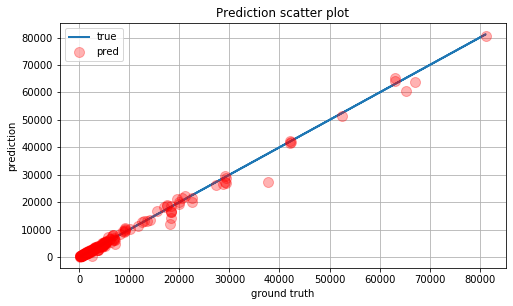

In [29]:
ckpt_dir = './model_checkpoint/'
loss = 'mse'
model_name = 'ours_t_v3_'+loss+'_2000_300_150_20_16_log'
model = load_model(ckpt_dir+model_name+'.h5')

x_train,y_train,x_test,y_test =data_load(2)
model_predict(2)

In [30]:
save_dir = './3D grad cam/'

In [165]:
def make_ax():
    fig = plt.figure(figsize=(5,5))
    fig.tight_layout()
    ax = fig.gca(projection='3d')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.grid(False)
    ax.axis('off')
    ax.view_init(rot1,rot2)
    return ax

def normalize(arr):
    arr_min = np.min(arr)
    return (arr-arr_min)/(np.max(arr)-arr_min)

def explode(data):
    shape_arr = np.array(data.shape)
    size = shape_arr[:3]*2 - 1
    exploded = np.zeros(np.concatenate([size, shape_arr[3:]]), dtype=data.dtype)
    exploded[::2, ::2, ::2] = data
    return exploded

def expand_coordinates(indices):
    x, y, z = indices
    x[1::2, :, :] += 1
    y[:, 1::2, :] += 1
    z[:, :, 1::2] += 1
    return x, y, z

def plot_cube2(feature_map2,voxel):
    cube = feature_map2
    vox = voxel[0,:,:,:,0]
    IMG_DIM = 32
    cube = normalize(cube)
    facecolors = cm.jet(cube)

    facecolors[:,:,:,-1] = cube
    facecolors = explode(facecolors)

    vox = explode(vox)

    filled = facecolors[:,:,:,-1] != 0

    for i in range(63):
        for j in range(63):
            for k in range(63):
                if vox[i,j,k]==0:
                    filled[i,j,k] = False
                elif vox[i,j,k]==1:
                    filled[i,j,k] = True

    x, y, z = expand_coordinates(np.indices(np.array(filled.shape) + 1))
    
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111,projection='3d')
    ax.grid(False)
    ax.axis('off')
    ax.view_init(rot1,rot2)
    ax.voxels(x, y, z, filled, facecolors=facecolors,edgecolors=(50 / 255, 50 / 255, 50 / 255)
            ,linewidths=0.1,alpha=0.4)
    plt.show()
    
def grad_cam(target_layer):
    img_output = model.output[:]
    last_conv_layer = model.get_layer(target_layer)
    grads = K.gradients(img_output,last_conv_layer.output)[0]
    gap_grads = K.mean(grads, axis=(0,1,2))
    
    iterate = K.function(model.input,
                      [gap_grads,last_conv_layer.output[0]])
    
    weights,feature_maps=iterate([voxel,mat,vol])

    #for i in range(weights.shape[1]):
    #    feature_maps[:,:,:,i] *= weights[:,i]
    #feature_maps = feature_maps*weights
    n = feature_maps.shape[0]
    temp = np.zeros([n,n,n])
    
    for i in range(feature_maps.shape[-1]):
        temp += np.maximum(0,feature_maps[:,:,:,i])
    return temp

In [132]:
#shape check

voxels = x_test[0]
mats = x_test[1]
volumes = x_test[2]
costs = y_test[:]

print('voxel:{},mats:{},volumes:{},costs:{}'.format(voxels.shape,mats.shape,volumes.shape,costs.shape))

voxel:(201, 32, 32, 32, 1),mats:(201, 16),volumes:(201,),costs:(201,)


In [133]:
index = []
for i in range(len(y_true)):
    m = mape2(y_true[i], y_pred[i])
    if m < 1:
        index.append(i)

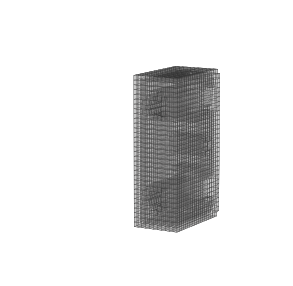

(12, 12, 12) --> (32, 32, 32)


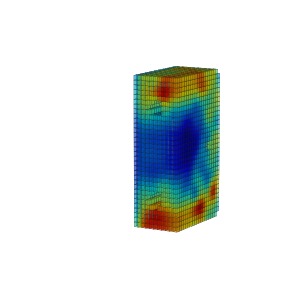

In [209]:
idx = 34
rot1,rot2 = 10,210
voxel = voxels[idx].reshape(1,32,32,32,1)
voxel_size = 32
mat = mats[idx].reshape(1,16)
vol = volumes[idx].reshape(1,1)
ax = make_ax()
filled = ax.voxels(voxel[0,:,:,:,0],facecolors='#d0cfcf'
              ,edgecolors=(50 / 255, 50 / 255, 50 / 255)
              ,linewidths=0.2,alpha=0.3)
plt.show()
target_layer = 'conv3'
feature_map = grad_cam(target_layer)
n = 32/feature_map.shape[0]
new_array = zoom(feature_map,(n,n,n))
print(feature_map.shape,'-->',new_array.shape)
plot_cube2(new_array,voxel)

In [217]:
new_array = zoom(feature_map,(0.5,0.5,0.5))

0


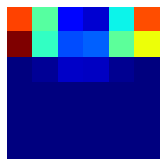

1


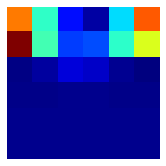

2


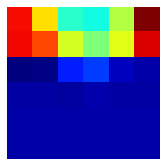

3


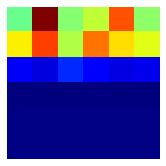

4


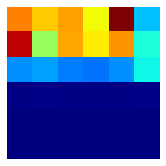

5


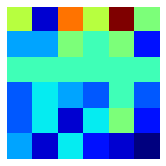

In [219]:
v = voxel[0,:,:,:,0]
for i in range(len(new_array)):
    plt.subplot(1,2,2)
    print(i)
    plt.imshow(new_array[i],'jet')
    plt.axis('off')
    plt.show()

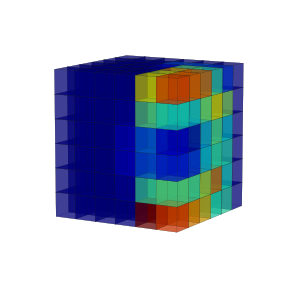

In [202]:
def plot_cube(feature_map2):
    cube = feature_map2
    IMG_DIM = 32
    cube = normalize(cube)
    facecolors = cm.jet(cube)

    facecolors[:,:,:,-1] = cube
    facecolors = explode(facecolors)

    filled = facecolors[:,:,:,-1] != 0

    x, y, z = expand_coordinates(np.indices(np.array(filled.shape) + 1))
    
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111,projection='3d')
    ax.grid(False)
    ax.axis('off')
    ax.view_init(10,210)
    ax.voxels(x, y, z, filled, facecolors=facecolors,edgecolors=(50 / 255, 50 / 255, 50 / 255)
            ,linewidths=0.1,alpha=0.5)
    plt.show()
plot_cube(new_array)

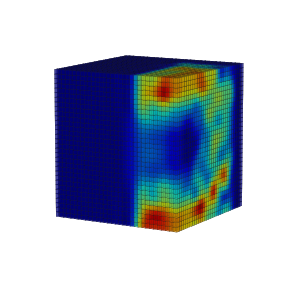

In [210]:
def plot_cube(feature_map2):
    cube = feature_map2
    IMG_DIM = 32
    cube = normalize(cube)
    facecolors = cm.jet(cube)

    facecolors[:,:,:,-1] = cube
    facecolors = explode(facecolors)

    filled = facecolors[:,:,:,-1] != 0

    x, y, z = expand_coordinates(np.indices(np.array(filled.shape) + 1))
    
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111,projection='3d')
    ax.grid(False)
    ax.axis('off')
    ax.view_init(10,210)
    ax.voxels(x, y, z, filled, facecolors=facecolors,edgecolors=(50 / 255, 50 / 255, 50 / 255)
            ,linewidths=0.1,alpha=0.5)
    plt.show()
plot_cube(new_array)